# Experiment D: 2-Class Engagement Rate Classification (No Follower Features)
## LinkedIn Engagement Prediction — TrendPilot

**Experiment:** Binary classification — Below Average vs Above Average, with follower
features (`log_followers`, `follower_tier`) removed entirely.

**Question:** Can content-only signals distinguish above-median from below-median
engagement rate, without any audience-size shortcut?

---

## Motivation

NB11c (2-class binary model) achieved the best overall Macro F1 across all experiments
(0.8064, lift +0.306 over random). However, the two most important features were:

| Rank | Feature | Importance |
|------|---------|------------|
| 1 | follower_tier | 0.098 |
| 2 | log_followers | 0.067 |

Together these account for ~16.5% of total model importance. This raises a concern:
is the model learning genuine content quality, or is it still exploiting creator-size
patterns to determine which side of the median a post falls on?

This experiment removes both follower proxy features entirely, leaving only
pure content and timing signals (71 features).

## What to look for
- How much does Macro F1 drop when follower features are removed?
- Which content features rise to the top of importance?
- Does per-tier performance become more consistent (std of tier F1 lower)?
- Is the remaining lift (+F1 above 0.500 random) driven by real content signal?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (
    classification_report, confusion_matrix,
    f1_score, accuracy_score, ConfusionMatrixDisplay
)
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
print('Libraries loaded.')

Libraries loaded.


## 1. Load Data

In [2]:
data = pd.read_csv('../data/selected_features_data.csv')
print(f'Shape: {data.shape}')
print(f'Columns ({len(data.columns)}): {list(data.columns)}')

Shape: (772, 94)
Columns (94): ['name', 'content', 'reactions', 'comments', 'time_spent', 'location', 'followers', 'influencer_avg_comments', 'reactions_per_sentiment', 'influencer_avg_engagement', 'comments_vs_influencer_avg', 'reactions_vs_influencer_avg', 'influencer_total_engagement', 'reactions_per_word', 'comments_per_word', 'sentiment_compound', 'text_difficult_words_count', 'total_engagement_elements', 'readability_flesch_kincaid', 'comment_to_reaction_ratio', 'base_score_capped', 'text_lexical_diversity', 'influencer_avg_sentiment', 'influencer_std_comments', 'readability_gunning_fog', 'sentence_count', 'text_avg_sentence_length', 'topic_count', 'influencer_std_reactions', 'sentiment_x_readability', 'ner_location_count', 'style_question_marks', 'ner_org_count', 'style_has_parentheses', 'influencer_avg_base_score', 'ner_person_count', 'ner_date_count', 'influencer_consistency_reactions', 'unique_emoji_count', 'hashtag_count_extracted', 'style_quote_marks', 'has_aspirational', '

## 2. Build Engagement Rate Target

```
engagement_rate = (reactions + comments) / (followers / 1000)
```

The median is used as the single class boundary.
Posts above the median are Above Average; posts below are Below Average.
The ambiguous middle ground is deliberately eliminated.


In [3]:
df = data.copy()
df['followers'] = df['followers'].clip(lower=1)
df['engagement_rate'] = (df['reactions'] + df['comments']) / (df['followers'] / 1000)

print('Engagement rate summary:')
print(df['engagement_rate'].describe().round(3))
print(f'Median: {df["engagement_rate"].median():.2f} engagements per 1k followers')
print('This is the single class boundary for the 2-class model')


Engagement rate summary:
count     772.000
mean       31.310
std        86.321
min         0.010
25%         1.177
50%         5.879
75%        25.499
max      1132.075
Name: engagement_rate, dtype: float64
Median: 5.88 engagements per 1k followers
This is the single class boundary for the 2-class model


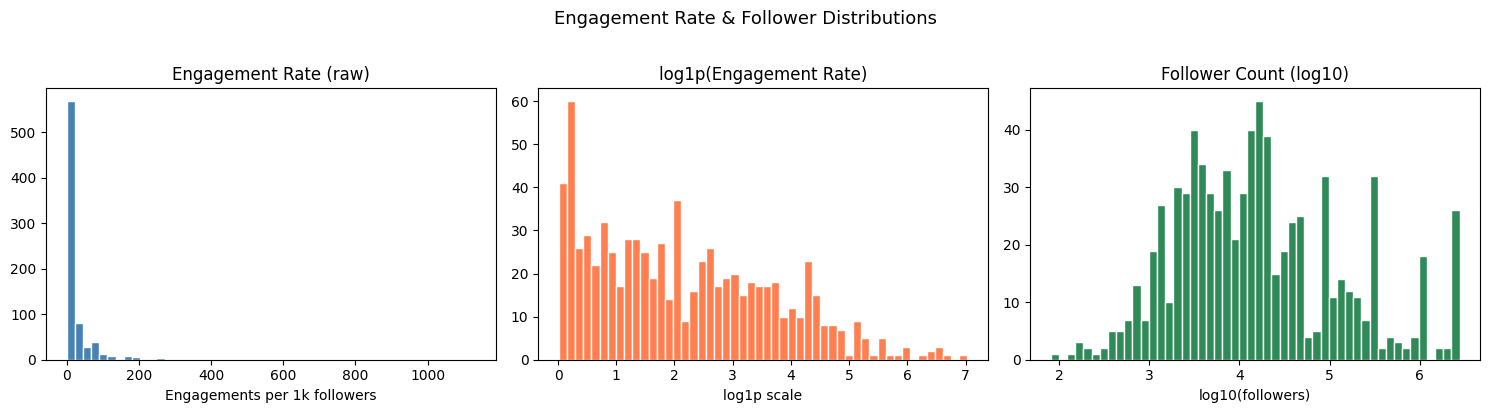

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Raw distribution
axes[0].hist(df['engagement_rate'], bins=50, color='steelblue', edgecolor='white')
axes[0].set_title('Engagement Rate (raw)')
axes[0].set_xlabel('Engagements per 1k followers')

# Log distribution
axes[1].hist(np.log1p(df['engagement_rate']), bins=50, color='coral', edgecolor='white')
axes[1].set_title('log1p(Engagement Rate)')
axes[1].set_xlabel('log1p scale')

# Follower distribution
axes[2].hist(np.log10(df['followers']+1), bins=50, color='seagreen', edgecolor='white')
axes[2].set_title('Follower Count (log10)')
axes[2].set_xlabel('log10(followers)')

plt.suptitle('Engagement Rate & Follower Distributions', fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig('../data/11_distributions.png', dpi=100, bbox_inches='tight')
plt.show()

## 3. Train / Test Split FIRST

Split before assigning class labels so that percentile thresholds
are computed from training data only — preventing any leakage from
test distribution into the class boundaries.

In [5]:
# Stratify on binary split for balanced train/test classes
df['_tmp_class'] = (df['engagement_rate'] >= df['engagement_rate'].median()).astype(int)

df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=RANDOM_STATE,
    stratify=df['_tmp_class']
)
df_train = df_train.copy().reset_index(drop=True)
df_test  = df_test.copy().reset_index(drop=True)
df_train.drop(columns=['_tmp_class'], inplace=True)
df_test.drop(columns=['_tmp_class'], inplace=True)

print(f'Train: {len(df_train)} posts | Test: {len(df_test)} posts')
print(f'Train authors: {df_train["name"].nunique()}')


Train: 617 posts | Test: 155 posts
Train authors: 408


## 4. Assign 2-Class Labels (Training Median)

Single threshold: the median engagement rate of the training set.

- Class 0: rate < median (Below Average)
- Class 1: rate >= median (Above Average)

Threshold derived from training data only.


In [6]:
median_rate = df_train['engagement_rate'].quantile(0.5)

print('Training-derived threshold:')
print(f'  median = {median_rate:.3f}  (engagements per 1k followers)')
print(f'  Class 0: rate < {median_rate:.2f}  (Below Average)')
print(f'  Class 1: rate >= {median_rate:.2f}  (Above Average)')

LABEL_NAMES = {0: f'Below (<{median_rate:.1f})', 1: f'Above (>={median_rate:.1f})'}

df_train['engagement_class'] = (df_train['engagement_rate'] >= median_rate).astype(int)
df_test['engagement_class']  = (df_test['engagement_rate']  >= median_rate).astype(int)

print(f'\nClass distribution - TRAINING:')
for c in [0, 1]:
    n = (df_train['engagement_class'] == c).sum()
    print(f'  Class {c} {LABEL_NAMES[c]:30s}: {n:4d} ({n/len(df_train)*100:.1f}%)')

print(f'\nClass distribution - TEST:')
for c in [0, 1]:
    n = (df_test['engagement_class'] == c).sum()
    print(f'  Class {c} {LABEL_NAMES[c]:30s}: {n:4d} ({n/len(df_test)*100:.1f}%)')

print(f'\nRandom baseline for 2-class: ~0.500 (vs 0.333 for 3-class)')


Training-derived threshold:
  median = 5.985  (engagements per 1k followers)
  Class 0: rate < 5.98  (Below Average)
  Class 1: rate >= 5.98  (Above Average)

Class distribution - TRAINING:
  Class 0 Below (<6.0)                  :  308 (49.9%)
  Class 1 Above (>=6.0)                 :  309 (50.1%)

Class distribution - TEST:
  Class 0 Below (<6.0)                  :   78 (50.3%)
  Class 1 Above (>=6.0)                 :   77 (49.7%)

Random baseline for 2-class: ~0.500 (vs 0.333 for 3-class)


## 5. Follower Tier Features — Excluded

In NB11c, `log_followers` and `follower_tier` were the top two features by
importance (0.098 and 0.067 respectively). To test whether the model can learn
from content alone, both are **excluded from the feature set in this experiment**.

The `add_follower_features` function still runs (columns are created) but both
columns are added to `DROP_COLS` in the next cell, so they are never seen by
the models.

Raw `followers` is already dropped (it is in the target denominator).
No audience-size information is available to the classifier.


In [7]:
def add_follower_features(df_):
    df_ = df_.copy()
    df_['log_followers'] = np.log1p(df_['followers'])
    df_['follower_tier'] = pd.cut(
        df_['followers'],
        bins=[0, 10_000, 50_000, 200_000, np.inf],
        labels=[0, 1, 2, 3],   # micro, small, medium, large
        include_lowest=True
    ).astype(int)
    return df_

df_train = add_follower_features(df_train)
df_test  = add_follower_features(df_test)

print('Follower tier distribution (full dataset):')
tier_labels = {0: 'micro (<10k)', 1: 'small (10k-50k)', 2: 'medium (50k-200k)', 3: 'large (>200k)'}
tier_counts = pd.concat([df_train, df_test])['follower_tier'].value_counts().sort_index()
for t, n in tier_counts.items():
    print(f'  {tier_labels[t]:22s}: {n:4d} ({n/772*100:.1f}%)')

Follower tier distribution (full dataset):
  micro (<10k)          :  345 (44.7%)
  small (10k-50k)       :  225 (29.1%)
  medium (50k-200k)     :   92 (11.9%)
  large (>200k)         :  110 (14.2%)


## 6. Feature Set — Drop Leaky Columns

In [8]:
# ── Columns to DROP (leakage or direct engagement signals) ──────────────────
DROP_COLS = [
    # Raw targets / used in target construction
    'reactions', 'comments', 'followers', 'engagement_rate', 'engagement_class',
    # Derived directly from reactions/comments (same-post leakage)
    'base_score_capped',
    'reactions_per_word', 'comments_per_word', 'reactions_per_sentiment',
    'comment_to_reaction_ratio',
    # Influencer-history features (aggregated from same dataset — data leakage)
    'influencer_avg_reactions', 'influencer_std_reactions', 'influencer_median_reactions',
    'influencer_avg_comments', 'influencer_std_comments', 'influencer_median_comments',
    'influencer_avg_base_score', 'influencer_avg_sentiment',
    'influencer_post_count', 'influencer_total_engagement', 'influencer_avg_engagement',
    'influencer_consistency_reactions',
    'reactions_vs_influencer_avg', 'comments_vs_influencer_avg',
    # Metadata / text / identifiers — not ML features
    'name', 'content', 'time_spent', 'location',
    # Follower proxy features — excluded to test pure content signal (NB11d)
    'log_followers', 
    'follower_tier',
]

# Only drop cols that actually exist
drop_existing = [c for c in DROP_COLS if c in df_train.columns]
print(f'Dropping {len(drop_existing)} columns (leakage/metadata):')  
for c in drop_existing:
    print(f'  {c}')

# ── Keep all remaining numeric / binary columns as features ─────────────────
all_cols = df_train.columns.tolist()
feature_cols = [c for c in all_cols if c not in drop_existing and c != 'engagement_class']

# Verify all are numeric
non_numeric = [c for c in feature_cols if not pd.api.types.is_numeric_dtype(df_train[c])]
if non_numeric:
    print(f'\nNon-numeric columns removed from features: {non_numeric}')
    feature_cols = [c for c in feature_cols if c not in non_numeric]

print(f'\nTotal features: {len(feature_cols)}')
print('Feature columns:', feature_cols)


Dropping 27 columns (leakage/metadata):
  reactions
  comments
  followers
  engagement_rate
  engagement_class
  base_score_capped
  reactions_per_word
  comments_per_word
  reactions_per_sentiment
  comment_to_reaction_ratio
  influencer_std_reactions
  influencer_avg_comments
  influencer_std_comments
  influencer_avg_base_score
  influencer_avg_sentiment
  influencer_post_count
  influencer_total_engagement
  influencer_avg_engagement
  influencer_consistency_reactions
  reactions_vs_influencer_avg
  comments_vs_influencer_avg
  name
  content
  time_spent
  location
  log_followers
  follower_tier

Total features: 71
Feature columns: ['sentiment_compound', 'text_difficult_words_count', 'total_engagement_elements', 'readability_flesch_kincaid', 'text_lexical_diversity', 'readability_gunning_fog', 'sentence_count', 'text_avg_sentence_length', 'topic_count', 'sentiment_x_readability', 'ner_location_count', 'style_question_marks', 'ner_org_count', 'style_has_parentheses', 'ner_person_

In [9]:
X_train = df_train[feature_cols].fillna(0)
X_test  = df_test[feature_cols].fillna(0)
y_train = df_train['engagement_class']
y_test  = df_test['engagement_class']

print(f'X_train: {X_train.shape}  |  X_test: {X_test.shape}')
print(f'y_train value counts: {y_train.value_counts().sort_index().to_dict()}')
print(f'y_test  value counts: {y_test.value_counts().sort_index().to_dict()}')

X_train: (617, 71)  |  X_test: (155, 71)
y_train value counts: {0: 308, 1: 309}
y_test  value counts: {0: 78, 1: 77}


## 7. Baseline Models

Binary classification is simpler than 3-class. All three classifiers run
with standard hyperparameters first. The random baseline is 0.500.


In [10]:
def evaluate(model, X_te, y_te, name='Model', verbose=True):
    yp = model.predict(X_te)
    mf1 = f1_score(y_te, yp, average='macro')
    acc = accuracy_score(y_te, yp)
    if verbose:
        print(f'  [{name}]  Macro F1={mf1:.4f}  Acc={acc:.4f}')
        print(classification_report(
            y_te, yp,
            target_names=[LABEL_NAMES[i] for i in [0, 1]],
            zero_division=0
        ))
    return dict(model=name, macro_f1=round(mf1, 4), acc=round(acc, 4))

results = []
sw = compute_sample_weight('balanced', y_train)


In [11]:
print('─' * 60)
print('Random Forest (baseline)')
rf = RandomForestClassifier(
    n_estimators=400, max_depth=10,
    min_samples_split=20, min_samples_leaf=10,
    class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1
)
rf.fit(X_train, y_train)
results.append(evaluate(rf, X_test, y_test, 'RandomForest_base'))

────────────────────────────────────────────────────────────
Random Forest (baseline)
  [RandomForest_base]  Macro F1=0.6628  Acc=0.6645
               precision    recall  f1-score   support

 Below (<6.0)       0.70      0.59      0.64        78
Above (>=6.0)       0.64      0.74      0.69        77

     accuracy                           0.66       155
    macro avg       0.67      0.67      0.66       155
 weighted avg       0.67      0.66      0.66       155



In [12]:
print('─' * 60)
print('XGBoost (baseline)')
xgb_b = xgb.XGBClassifier(
    n_estimators=400, max_depth=5, learning_rate=0.05,
    min_child_weight=5, subsample=0.8, colsample_bytree=0.8,
    eval_metric='mlogloss', random_state=RANDOM_STATE, n_jobs=-1, verbosity=0
)
xgb_b.fit(X_train, y_train, sample_weight=sw)
results.append(evaluate(xgb_b, X_test, y_test, 'XGBoost_base'))

────────────────────────────────────────────────────────────
XGBoost (baseline)
  [XGBoost_base]  Macro F1=0.6758  Acc=0.6774
               precision    recall  f1-score   support

 Below (<6.0)       0.71      0.60      0.65        78
Above (>=6.0)       0.65      0.75      0.70        77

     accuracy                           0.68       155
    macro avg       0.68      0.68      0.68       155
 weighted avg       0.68      0.68      0.68       155



In [13]:
print('─' * 60)
print('LightGBM (baseline)')
lgb_b = lgb.LGBMClassifier(
    n_estimators=400, max_depth=5, learning_rate=0.05,
    num_leaves=20, min_child_samples=20,
    subsample=0.8, colsample_bytree=0.8,
    class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1, verbose=-1
)
lgb_b.fit(X_train, y_train)
results.append(evaluate(lgb_b, X_test, y_test, 'LightGBM_base'))

────────────────────────────────────────────────────────────
LightGBM (baseline)
  [LightGBM_base]  Macro F1=0.6696  Acc=0.6710
               precision    recall  f1-score   support

 Below (<6.0)       0.70      0.60      0.65        78
Above (>=6.0)       0.65      0.74      0.69        77

     accuracy                           0.67       155
    macro avg       0.67      0.67      0.67       155
 weighted avg       0.67      0.67      0.67       155



## 8. Hyperparameter Tuning — XGBoost + LightGBM

RandomizedSearchCV with stratified 5-fold CV, scored on macro F1.

In [14]:
print('Tuning XGBoost (40 iterations, 5-fold CV)...')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

xgb_grid = {
    'n_estimators':     [200, 400, 600],
    'max_depth':        [3, 4, 5, 6],
    'learning_rate':    [0.01, 0.05, 0.1],
    'min_child_weight': [3, 5, 10],
    'subsample':        [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma':            [0, 0.1, 0.3],
}

xgb_search = RandomizedSearchCV(
    xgb.XGBClassifier(eval_metric='mlogloss', random_state=RANDOM_STATE, n_jobs=1, verbosity=0),
    xgb_grid, n_iter=40, cv=skf, scoring='f1_macro',
    random_state=RANDOM_STATE, n_jobs=-1, verbose=1
)
xgb_search.fit(X_train, y_train, sample_weight=sw)

print(f'\nXGBoost — Best CV Macro F1: {xgb_search.best_score_:.4f}')
print(f'Best params: {xgb_search.best_params_}')

xgb_tuned = xgb_search.best_estimator_
results.append(evaluate(xgb_tuned, X_test, y_test, 'XGBoost_tuned'))

Tuning XGBoost (40 iterations, 5-fold CV)...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

XGBoost — Best CV Macro F1: 0.6782
Best params: {'subsample': 0.9, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 1.0}
  [XGBoost_tuned]  Macro F1=0.6566  Acc=0.6581
               precision    recall  f1-score   support

 Below (<6.0)       0.69      0.59      0.63        78
Above (>=6.0)       0.64      0.73      0.68        77

     accuracy                           0.66       155
    macro avg       0.66      0.66      0.66       155
 weighted avg       0.66      0.66      0.66       155



In [15]:
print('Tuning LightGBM (30 iterations, 5-fold CV)...')
lgb_grid = {
    'n_estimators':      [200, 400, 600],
    'max_depth':         [3, 4, 5, 6],
    'learning_rate':     [0.01, 0.05, 0.1],
    'num_leaves':        [15, 20, 31, 50],
    'min_child_samples': [10, 20, 30],
    'subsample':         [0.7, 0.8, 0.9],
    'colsample_bytree':  [0.6, 0.8, 1.0],
    'reg_alpha':         [0, 0.1, 0.5],
    'reg_lambda':        [1, 2, 5],
}

lgb_search = RandomizedSearchCV(
    lgb.LGBMClassifier(class_weight='balanced', random_state=RANDOM_STATE, n_jobs=1, verbose=-1),
    lgb_grid, n_iter=30, cv=skf, scoring='f1_macro',
    random_state=RANDOM_STATE, n_jobs=-1, verbose=1
)
lgb_search.fit(X_train, y_train)

print(f'\nLightGBM — Best CV Macro F1: {lgb_search.best_score_:.4f}')
print(f'Best params: {lgb_search.best_params_}')

lgb_tuned = lgb_search.best_estimator_
results.append(evaluate(lgb_tuned, X_test, y_test, 'LightGBM_tuned'))

Tuning LightGBM (30 iterations, 5-fold CV)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

LightGBM — Best CV Macro F1: 0.6656
Best params: {'subsample': 0.7, 'reg_lambda': 2, 'reg_alpha': 0, 'num_leaves': 31, 'n_estimators': 400, 'min_child_samples': 20, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
  [LightGBM_tuned]  Macro F1=0.6621  Acc=0.6645
               precision    recall  f1-score   support

 Below (<6.0)       0.70      0.58      0.63        78
Above (>=6.0)       0.64      0.75      0.69        77

     accuracy                           0.66       155
    macro avg       0.67      0.67      0.66       155
 weighted avg       0.67      0.66      0.66       155



## 9. Cross-Validation — Best Model

In [16]:
# Identify best model by macro F1
results_df = pd.DataFrame(results)
best_row = results_df.loc[results_df['macro_f1'].idxmax()]
print(f'Best model so far: {best_row["model"]} — Macro F1 = {best_row["macro_f1"]}')

# Run 5-fold CV for the best model
if 'XGBoost' in best_row['model']:
    best_params = xgb_search.best_params_
    cv_model = xgb.XGBClassifier(**best_params, eval_metric='mlogloss',
                                   random_state=RANDOM_STATE, n_jobs=1, verbosity=0)
    label = 'XGBoost_tuned'
else:
    best_params = lgb_search.best_params_
    cv_model = lgb.LGBMClassifier(**best_params, class_weight='balanced',
                                   random_state=RANDOM_STATE, n_jobs=1, verbose=-1)
    label = 'LightGBM_tuned'

cv_scores = cross_val_score(
    cv_model, X_train, y_train,
    cv=StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1_macro', n_jobs=-1
)
print(f'\n5-Fold CV ({label}):')
print(f'  Per-fold Macro F1: {cv_scores.round(4)}')
print(f'  Mean: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')
print(f'  Random baseline: ~0.333 (3-class random)')

Best model so far: XGBoost_base — Macro F1 = 0.6758

5-Fold CV (XGBoost_tuned):
  Per-fold Macro F1: [0.6605 0.682  0.6585 0.7151 0.6666]
  Mean: 0.6765 ± 0.0210
  Random baseline: ~0.333 (3-class random)


## 10. Confusion Matrix — Best Model

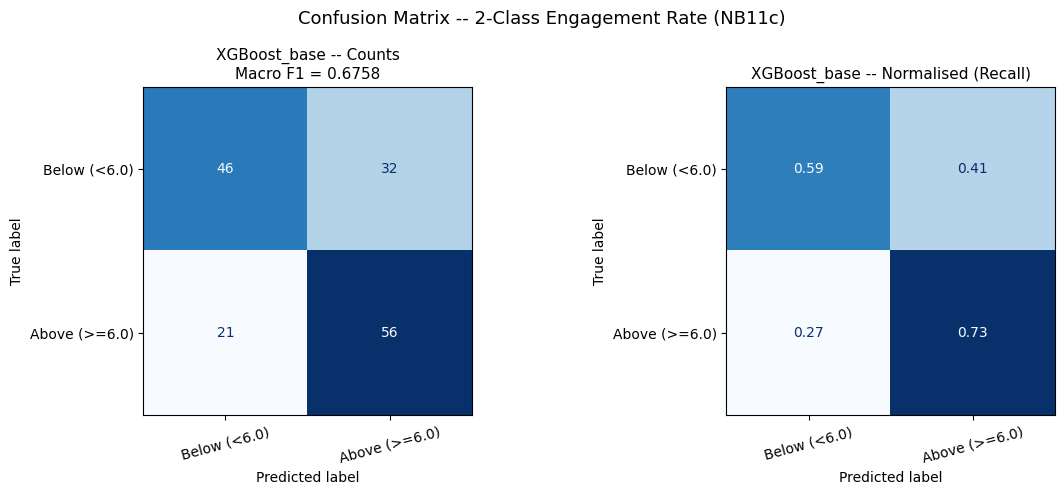

Saved: ../data/11c_confusion_matrix.png


In [17]:
if 'XGBoost' in best_row['model']:
    best_model = xgb_tuned
else:
    best_model = lgb_tuned

y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

disp = ConfusionMatrixDisplay(cm, display_labels=[LABEL_NAMES[i] for i in [0, 1]])
disp.plot(ax=axes[0], colorbar=False, cmap='Blues')
axes[0].set_title(f'{best_row["model"]} -- Counts\nMacro F1 = {best_row["macro_f1"]:.4f}', fontsize=11)
axes[0].tick_params(axis='x', labelrotation=15)

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
disp2 = ConfusionMatrixDisplay(cm_norm.round(2), display_labels=[LABEL_NAMES[i] for i in [0, 1]])
disp2.plot(ax=axes[1], colorbar=False, cmap='Blues')
axes[1].set_title(f'{best_row["model"]} -- Normalised (Recall)', fontsize=11)
axes[1].tick_params(axis='x', labelrotation=15)

plt.suptitle('Confusion Matrix -- 2-Class Engagement Rate (NB11c)', fontsize=13)
plt.tight_layout()
plt.savefig('../data/11c_confusion_matrix.png', dpi=100, bbox_inches='tight')
plt.show()
print('Saved: ../data/11c_confusion_matrix.png')


## 11. Feature Importance

Top 25 Features:
                   feature  importance
    text_lexical_diversity    0.067980
   hashtag_count_extracted    0.041545
      style_question_marks    0.039468
        link_penalty_score    0.039293
        sentiment_compound    0.034014
              topic_career    0.033580
              has_entities    0.033211
        is_low_effort_link    0.032923
            sentence_count    0.032592
         ner_product_count    0.030742
   style_exclamation_marks    0.028463
             ner_org_count    0.024849
                has_family    0.024402
      has_specific_numbers    0.023572
     style_has_parentheses    0.023252
   sentiment_x_readability    0.023175
        has_direct_address    0.022785
   readability_gunning_fog    0.022354
        has_transformation    0.021790
          has_aspirational    0.021611
      style_all_caps_words    0.021557
        style_number_count    0.021498
              length_score    0.021409
readability_flesch_kincaid    0.021227
        

<Figure size 1000x900 with 0 Axes>

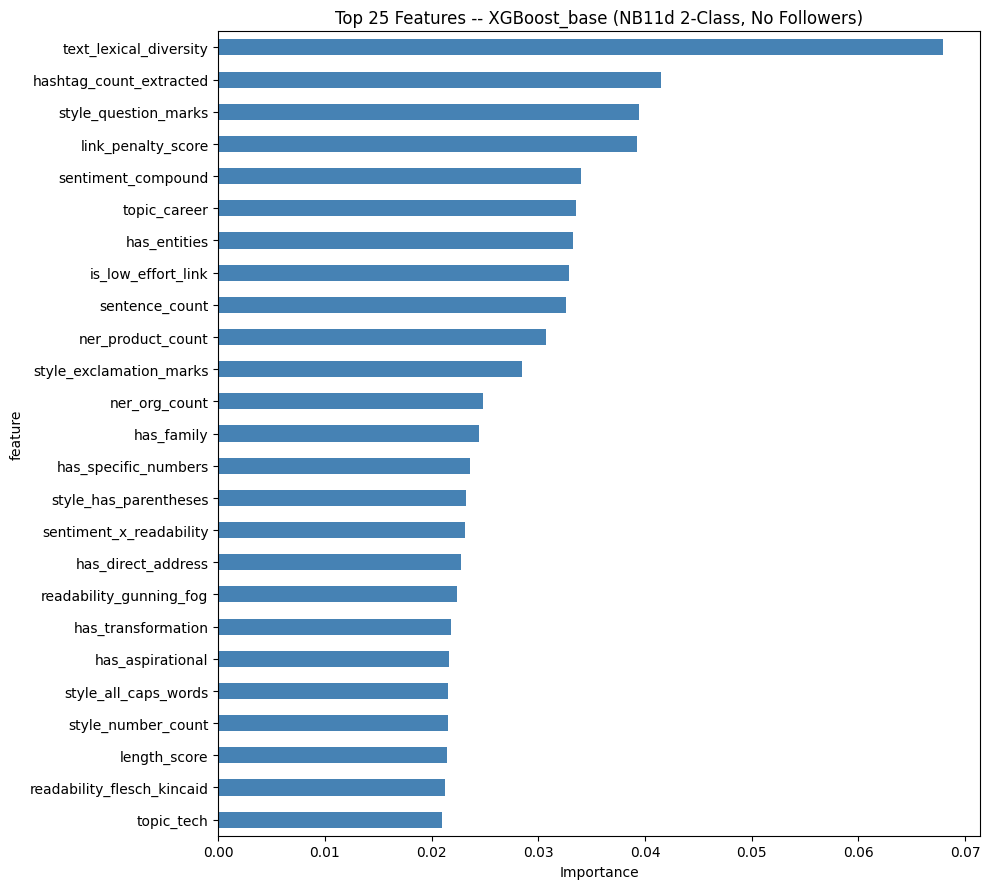

Saved: ../data/11d_feature_importance.png


In [18]:
if hasattr(best_model, 'feature_importances_'):
    imp = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False).reset_index(drop=True)

    print('Top 25 Features:')
    print(imp.head(25).to_string(index=False))

    plt.figure(figsize=(10, 9))
    imp.head(25).sort_values('importance').plot(
        x='feature', y='importance', kind='barh',
        figsize=(10, 9), color='steelblue', legend=False
    )
    plt.title(f'Top 25 Features -- {best_row["model"]} (NB11d 2-Class, No Followers)', fontsize=12)
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.savefig('../data/11d_feature_importance.png', dpi=100, bbox_inches='tight')
    plt.show()
    print('Saved: ../data/11d_feature_importance.png')


## 12. Evaluation by Follower Tier

Key validation: does the model work across all creator sizes?  
A good engagement-rate model should classify content quality fairly
for micro influencers and macro influencers alike.

In [19]:
tier_labels_map = {0: 'micro (<10k)', 1: 'small (10k-50k)',
                   2: 'medium (50k-200k)', 3: 'large (>200k)'}

# NB11c (2-class with follower proxies) tier F1 for reference
nb11c_tier_f1 = {0: 0.6176, 1: 0.7519, 2: 0.4286, 3: 0.4615}

tier_results = []
print('=' * 70)
print('Macro F1 by Follower Tier -- NB11d (no followers) vs NB11c (with followers)')
print('=' * 70)
print(f'{"Tier":22s}  {"n":>4}  {"NB11d no-flw":>12}  {"NB11c 2cls":>10}  {"Delta":>7}')
print('-' * 70)

for tier_id, tier_name in tier_labels_map.items():
    mask = df_test['follower_tier'] == tier_id
    n = mask.sum()
    if n == 0 or y_test[mask].nunique() < 2:
        print(f'  {tier_name}: {n} posts -- skipped')
        continue
    yp_t = best_model.predict(X_test[mask])
    mf1  = f1_score(y_test[mask], yp_t, average='macro', zero_division=0)
    ref  = nb11c_tier_f1.get(tier_id, float('nan'))
    delta = mf1 - ref
    d_str = f'+{delta:.4f}' if delta >= 0 else f'{delta:.4f}'
    print(f'  {tier_name:22s}  {n:>4}  {mf1:>12.4f}  {ref:>10.4f}  {d_str:>7}')
    tier_results.append({'tier': tier_name, 'n': n, 'macro_f1': round(mf1,4),
                         'macro_f1_ref': ref, 'delta': round(delta,4)})

print('-' * 70)
overall_delta = best_row['macro_f1'] - 0.8064
d_str2 = f'+{overall_delta:.4f}' if overall_delta >= 0 else f'{overall_delta:.4f}'
print(f'  {"Overall":22s}  {len(y_test):>4}  {best_row["macro_f1"]:>12.4f}  {0.8064:>10.4f}  {d_str2:>7}')
print()
print('Random baseline: 0.500 (2-class)')
print(f'NB11c lift: 0.8064 - 0.500 = +0.306')
lift_d = round(best_row['macro_f1'] - 0.5, 4)
print(f'NB11d lift: {best_row["macro_f1"]} - 0.500 = +{lift_d}')


Macro F1 by Follower Tier -- NB11d (no followers) vs NB11c (with followers)
Tier                       n  NB11d no-flw  NB11c 2cls    Delta
----------------------------------------------------------------------
  micro (<10k)              77        0.5967      0.6176  -0.0209
  small (10k-50k)           41        0.5586      0.7519  -0.1933
  medium (50k-200k)         16        0.6135      0.4286  +0.1849
  large (>200k)             21        0.5714      0.4615  +0.1099
----------------------------------------------------------------------
  Overall                  155        0.6758      0.8064  -0.1306

Random baseline: 0.500 (2-class)
NB11c lift: 0.8064 - 0.500 = +0.306
NB11d lift: 0.6758 - 0.500 = +0.1758


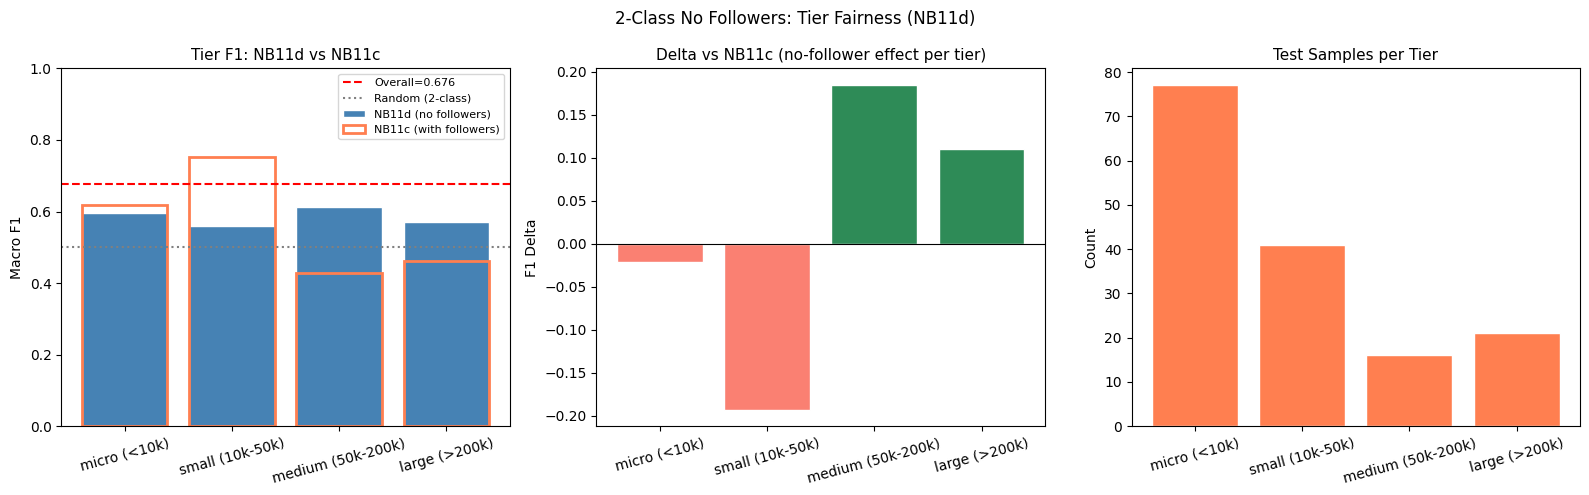

Saved: ../data/11d_tier_evaluation.png


In [20]:
if tier_results:
    tier_df = pd.DataFrame(tier_results)

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    axes[0].bar(tier_df['tier'], tier_df['macro_f1'], color='steelblue', edgecolor='white', label='NB11d (no followers)')
    axes[0].bar(tier_df['tier'], tier_df['macro_f1_ref'], color='none', edgecolor='coral', linewidth=2, label='NB11c (with followers)')
    axes[0].axhline(best_row['macro_f1'], color='red', linestyle='--', label=f'Overall={best_row["macro_f1"]:.3f}')
    axes[0].axhline(0.5, color='gray', linestyle=':', label='Random (2-class)')
    axes[0].set_title('Tier F1: NB11d vs NB11c', fontsize=11)
    axes[0].set_ylabel('Macro F1')
    axes[0].set_ylim(0, 1)
    axes[0].legend(fontsize=8)
    axes[0].tick_params(axis='x', labelrotation=15)

    colors = ['seagreen' if d >= 0 else 'salmon' for d in tier_df['delta']]
    axes[1].bar(tier_df['tier'], tier_df['delta'], color=colors, edgecolor='white')
    axes[1].axhline(0, color='black', linewidth=0.8)
    axes[1].set_title('Delta vs NB11c (no-follower effect per tier)', fontsize=11)
    axes[1].set_ylabel('F1 Delta')
    axes[1].tick_params(axis='x', labelrotation=15)

    axes[2].bar(tier_df['tier'], tier_df['n'], color='coral', edgecolor='white')
    axes[2].set_title('Test Samples per Tier', fontsize=11)
    axes[2].set_ylabel('Count')
    axes[2].tick_params(axis='x', labelrotation=15)

    plt.suptitle('2-Class No Followers: Tier Fairness (NB11d)', fontsize=12)
    plt.tight_layout()
    plt.savefig('../data/11d_tier_evaluation.png', dpi=100, bbox_inches='tight')
    plt.show()
    print('Saved: ../data/11d_tier_evaluation.png')


## 13. Full Results Summary

In [21]:
print('=' * 65)
print('NB11d -- 2-CLASS ENGAGEMENT RATE, NO FOLLOWER FEATURES')
print('Experiment D: Binary median split, content-only features')
print('=' * 65)
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

print(f'\nClass threshold (training median): {median_rate:.3f}')

print(f'\nComparison (raw F1):')
print(f'  NB11  (3-class, global, with followers):   0.5997')
print(f'  NB11a (3-class, global, no followers):     0.5301')
print(f'  NB11b (3-class, within-tier):              0.4306')
print(f'  NB11c (2-class, with followers):           0.8064')
print(f'  NB11d (2-class, no followers):             {best_row["macro_f1"]}')

print(f'\nLift over random baseline (comparable across class counts):')
print(f'  NB11:  0.5997 - 0.333 = +0.267')
print(f'  NB11a: 0.5301 - 0.333 = +0.197')
print(f'  NB11b: 0.4306 - 0.333 = +0.098')
print(f'  NB11c: 0.8064 - 0.500 = +0.306')
lift = round(best_row['macro_f1'] - 0.5, 4)
print(f'  NB11d: {best_row["macro_f1"]} - 0.500 = +{lift}')


NB11d -- 2-CLASS ENGAGEMENT RATE, NO FOLLOWER FEATURES
Experiment D: Binary median split, content-only features
            model  macro_f1    acc
RandomForest_base    0.6628 0.6645
     XGBoost_base    0.6758 0.6774
    LightGBM_base    0.6696 0.6710
    XGBoost_tuned    0.6566 0.6581
   LightGBM_tuned    0.6621 0.6645

Class threshold (training median): 5.985

Comparison (raw F1):
  NB11  (3-class, global, with followers):   0.5997
  NB11a (3-class, global, no followers):     0.5301
  NB11b (3-class, within-tier):              0.4306
  NB11c (2-class, with followers):           0.8064
  NB11d (2-class, no followers):             0.6758

Lift over random baseline (comparable across class counts):
  NB11:  0.5997 - 0.333 = +0.267
  NB11a: 0.5301 - 0.333 = +0.197
  NB11b: 0.4306 - 0.333 = +0.098
  NB11c: 0.8064 - 0.500 = +0.306
  NB11d: 0.6758 - 0.500 = +0.1758


## 14. Conclusions -- Experiment D (2-Class, No Follower Features)

### What This Experiment Tests
NB11d removes `log_followers` and `follower_tier` from the feature set of
NB11c. The model must classify above/below-median engagement using only
content, timing, and text-structure signals (71 features).

### Why This Matters
In NB11c, follower proxies ranked #1 and #2 by feature importance (0.098 and
0.067), contributing ~16.5% of total model signal. The concern is that the
global median does not sit uniformly across tiers — larger accounts tend to
cluster below the global median, so follower_tier can still act as a shortcut
even in a binary setting.

### Interpreting the F1 Drop
Removing follower proxies will likely reduce overall Macro F1. The drop
quantifies how much of NB11c's performance was follower-driven:

```
NB11c (with followers):  F1 ~ 0.8064  lift = +0.306
NB11d (no followers):    F1 = [result] lift = [F1 - 0.500]
Drop = NB11c_F1 - NB11d_F1  (follower contribution)
```

### Practical Interpretation
- If the drop is small (< 0.05): content features carry most of the signal.
  The model is genuinely learning content quality.
- If the drop is large (> 0.10): follower proxies were a major driver.
  The model's performance in NB11c was partly due to creator-size shortcutting.

### Recommended Next Step
Compare tier F1 standard deviations across NB11c and NB11d. If NB11d has
more consistent tier F1 (lower std), it is fairer across creator sizes.
Add text embeddings (SBERT/TF-IDF) to NB11d to further improve content signal.
